In [1]:
import numpy as np
import pandas as pd
import quandl
import datetime
import matplotlib.pyplot as plt

In [2]:
start = datetime.datetime(2010,1,1)
end = datetime.date.today()

In [3]:
quandl.ApiConfig.api_key = 'xE6hSTRjfcDRnFScKkz-'
apple, microsoft, google, facebook, twitter, netflix, amazon = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["AAPL", "MSFT", "GOOG", "FB", "TWTR", "NFLX", "AMZN"])

In [4]:
stocks=[apple, microsoft, google, facebook, twitter, netflix, amazon]

In [5]:
apple.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,17633200.0,0.0,1.0,27.428730,27.566240,27.293790,27.503268,123432400.0
2010-01-05,214.60,215.59,213.25,214.38,21496600.0,0.0,1.0,27.579091,27.706320,27.405597,27.550818,150476200.0
2010-01-06,214.38,215.23,210.75,210.97,19720000.0,0.0,1.0,27.550818,27.660055,27.084312,27.112585,138040000.0
2010-01-07,211.75,212.00,209.05,210.58,17040400.0,0.0,1.0,27.212826,27.244955,26.865839,27.062465,119282800.0
2010-01-08,210.30,212.00,209.06,211.98,15986100.0,0.0,1.0,27.026481,27.244955,26.867124,27.242385,111902700.0


In [6]:
for s in stocks:
    s.drop(s.columns[[4,5,6,7,8,9,11]], axis =1, inplace = True)
    

In [7]:
for s in stocks:
    s['Open-Open'] = s['Open'] - s['Open'].shift(3)
    s['S_10'] = s['Close'].rolling(window=10).mean()
    

In [8]:
for s in stocks:
    s=s.dropna(how='any', inplace = True)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [10]:
def strategy(stocks):
    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for df in stocks:
        X = df[1].iloc[:,:]
        X.dropna()
        y = np.where(df[1]['Adj. Close'].shift(-3) > df[1]['Adj. Close'],1,-1)
        
        split = int(0.7*len(df[1]))
        X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
        model = LogisticRegression()
        model = model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[1]['Regime'] = model.predict(X)
        
        regime_orig = df[1].loc[:, "Regime"].iloc[-1]
        df[1].loc[:, "Regime"].iloc[-1] = 0
        df[1]["Signal"] = np.sign(df[1]["Regime"] - df[1]["Regime"].shift(1))
        df[1].loc[:, "Regime"].iloc[-1] = regime_orig
        
        signals = pd.concat([
            pd.DataFrame({"Price": df[1].loc[df[1]["Signal"] == 1, "Adj. Close"],
                         "Regime": df[1].loc[df[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": df[1].loc[df[1]["Signal"] == -1, "Adj. Close"],
                         "Regime": df[1].loc[df[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        
        signals.index = pd.MultiIndex.from_product([signals.index, [df[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)
        

    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])
 
    return trades
 



In [11]:
signals = strategy([("AAPL", apple),
                    ("MSFT",  microsoft),
                    ("GOOG",  google),
                    ("FB",  facebook),
                    ("TWTR",  twitter),
                    ("NFLX",  netflix),
                    ("AMZN",  amazon)])

signals

/home/gaurav/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gaurav/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/gaurav/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/gaurav/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.or

Price  Regime Signal
Date       Symbol                            
2010-01-29 AMZN     125.410000    -1.0   Sell
2010-02-01 AMZN     118.870000     1.0    Buy
           MSFT      23.089180     1.0    Buy
2010-02-02 MSFT      23.129816    -1.0   Sell
2010-04-22 NFLX      14.321429    -1.0   Sell
2010-04-23 NFLX      14.247143     1.0    Buy
2010-05-13 NFLX      15.715714    -1.0   Sell
2010-05-14 NFLX      14.365714     1.0    Buy
2010-05-21 MSFT      22.012861     1.0    Buy
2010-06-03 MSFT      22.029264    -1.0   Sell
2010-06-07 MSFT      20.741626     1.0    Buy
2010-06-15 MSFT      21.801672    -1.0   Sell
2010-06-23 MSFT      20.756389     1.0    Buy
2010-06-24 MSFT      20.503782    -1.0   Sell
2010-06-25 MSFT      20.120361     1.0    Buy
2010-07-07 NFLX      16.927143    -1.0   Sell
2010-07-08 NFLX      16.711429     1.0    Buy
2010-07-12 MSFT      20.364356    -1.0   Sell
2010-07-30 MSFT      21.168105     1.0    Buy
2010-08-02 MSFT      21.594583    -1.0   Sell
2010-08-04 AMZN     127.580000    -1.0   Sell
           MSFT      21.102493     1.0    Buy
2010-08-05 AMZN     127.830000     1.0    Buy
2010-08-06 NFLX      16.902857    -1.0   Sell
2010-08-09 NFLX      16.700000     1.0    Buy
2010-08-10 NFLX      17.858571    -1.0   Sell
2010-08-11 NFLX      18.067143     1.0    Buy
2010-09-03 AMZN     138.790000    -1.0   Sell
2010-09-07 AMZN     137.220000     1.0    Buy
2010-09-13 MSFT      20.702344    -1.0   Sell
...                        ...     ...    ...
2018-02-23 TWTR      32.660000    -1.0   Sell
2018-02-27 FB       181.460000     1.0    Buy
2018-02-28 GOOG    1104.730000     1.0    Buy
2018-03-02 AMZN    1500.250000     1.0    Buy
           MSFT      93.050000     1.0    Buy
2018-03-05 MSFT      93.640000    -1.0   Sell
2018-03-06 AMZN    1537.640000    -1.0   Sell
2018-03-07 FB       183.710000    -1.0   Sell
           MSFT      93.860000     1.0    Buy
2018-03-08 GOOG    1126.000000    -1.0   Sell
2018-03-09 MSFT      96.540000    -1.0   Sell
2018-03-13 FB       181.880000     1.0    Buy
           TWTR      34.110000     1.0    Buy
2018-03-14 TWTR      36.600000    -1.0   Sell
2018-03-15 AMZN    1582.320000     1.0    Buy
           MSFT      94.180000     1.0    Buy
           TWTR      35.800000     1.0    Buy
2018-03-16 MSFT      94.600000    -1.0   Sell
           TWTR      35.580000    -1.0   Sell
2018-03-19 GOOG    1099.820000     1.0    Buy
           MSFT      92.890000     1.0    Buy
2018-03-20 TWTR      31.350000     1.0    Buy
2018-03-21 TWTR      32.730000    -1.0   Sell
2018-03-27 AAPL     168.340000    -1.0    Buy
           AMZN    1497.050000    -1.0   Sell
           FB       152.190000     1.0   Sell
           GOOG    1005.100000     1.0   Sell
           MSFT      89.470000    -1.0   Sell
           NFLX     300.690000     1.0   Sell
           TWTR      28.070000     1.0    Buy

[1315 rows x 3 columns]

In [12]:
def backtest(signals, cash, port_value = .1, batch = 100):
   
 
    SYMBOL = 1 
    portfolio = dict()
    port_prices = dict()
    short_dict=dict()
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": [],
                            "Shorted Val": []})
 
    for index, row in signals.iterrows():
        shares = portfolio.setdefault(index[SYMBOL], 0)
        short_shares= short_dict.setdefault(index[SYMBOL], 0)
        trade_val = 0
        short_val=0
        batches = 0
        cash_change = row["Price"] * shares   
        portfolio[index[SYMBOL]] = 0 
        
        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]
 
        if row["Signal"] == "Buy" and row["Regime"] == 1: 
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"])
            trade_val = batches * batch * row["Price"] 
            cash_change -= trade_val 
            portfolio[index[SYMBOL]] = batches * batch 
            short_dict[index[SYMBOL]] = batches * batch 
            port_prices[index[SYMBOL]] = row["Price"]  
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1:
            shortsell = short_dict[index[SYMBOL]]*row["Price"]          
            short_val = shortsell
            
            
        
        pprofit = row["Price"] - old_price   
 
        
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val + short_val,
                "Type": row["Signal"],
                "Shares": short_dict[index[SYMBOL]],
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit,
                "Shorted Val": short_val
            }, index = [index]))
        cash += cash_change  
 
    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])
 
    return results

In [13]:
bk = backtest(signals, 1000000)
bk

Start Cash      End Cash  Portfolio Value  Type   Shares  \
Date       Symbol                                                               
2010-01-29 AMZN    1.000000e+06  1.000000e+06     1.000000e+06  Sell      0.0   
2010-02-01 AMZN    1.000000e+06  9.049040e+05     1.000000e+06   Buy    800.0   
           MSFT    9.049040e+05  8.056205e+05     1.000000e+06   Buy   4300.0   
2010-02-02 MSFT    8.056205e+05  9.050787e+05     1.099633e+06  Sell   4300.0   
2010-04-22 NFLX    9.050787e+05  9.050787e+05     1.000175e+06  Sell      0.0   
2010-04-23 NFLX    9.050787e+05  8.053487e+05     1.000175e+06   Buy   7000.0   
2010-05-13 NFLX    8.053487e+05  9.153587e+05     1.120465e+06  Sell   7000.0   
2010-05-14 NFLX    9.153587e+05  8.147987e+05     1.010455e+06   Buy   7000.0   
2010-05-21 MSFT    8.147987e+05  7.157409e+05     1.010455e+06   Buy   4500.0   
2010-06-03 MSFT    7.157409e+05  8.148725e+05     1.109660e+06  Sell   4500.0   
2010-06-07 MSFT    8.148725e+05  7.153127e+05     1.010529e+06   Buy   4800.0   
2010-06-15 MSFT    7.153127e+05  8.199608e+05     1.120265e+06  Sell   4800.0   
2010-06-23 MSFT    8.199608e+05  7.203301e+05     1.015617e+06   Buy   4800.0   
2010-06-24 MSFT    7.203301e+05  8.187483e+05     1.112822e+06  Sell   4800.0   
2010-06-25 MSFT    8.187483e+05  7.181464e+05     1.014404e+06   Buy   5000.0   
2010-07-07 NFLX    7.181464e+05  8.366364e+05     1.150824e+06  Sell   7000.0   
2010-07-08 NFLX    8.366364e+05  7.346967e+05     1.032334e+06   Buy   6100.0   
2010-07-12 MSFT    7.346967e+05  8.365185e+05     1.135376e+06  Sell   5000.0   
2010-07-30 MSFT    8.365185e+05  7.349116e+05     1.033554e+06   Buy   4800.0   
2010-08-02 MSFT    7.349116e+05  8.385656e+05     1.139255e+06  Sell   4800.0   
2010-08-04 AMZN    8.385656e+05  9.406296e+05     1.144633e+06  Sell    800.0   
           MSFT    9.406296e+05  8.372274e+05     1.042569e+06   Buy   4900.0   
2010-08-05 AMZN    8.372274e+05  7.349634e+05     1.042569e+06   Buy    800.0   
2010-08-06 NFLX    7.349634e+05  8.380708e+05     1.146844e+06  Sell   6100.0   
2010-08-09 NFLX    8.380708e+05  7.345308e+05     1.043737e+06   Buy   6200.0   
2010-08-10 NFLX    7.345308e+05  8.452540e+05     1.161643e+06  Sell   6200.0   
2010-08-11 NFLX    8.452540e+05  7.404645e+05     1.050920e+06   Buy   5800.0   
2010-09-03 AMZN    7.404645e+05  8.514965e+05     1.170720e+06  Sell    800.0   
2010-09-07 AMZN    8.514965e+05  7.554425e+05     1.059688e+06   Buy    700.0   
2010-09-13 MSFT    7.554425e+05  8.568840e+05     1.159169e+06  Sell   4900.0   
...                         ...           ...              ...   ...      ...   
2018-02-23 TWTR    2.352800e+06  2.627144e+06     3.104528e+06  Sell   8400.0   
2018-02-27 FB      2.627144e+06  2.354954e+06     2.830184e+06   Buy   1500.0   
2018-02-28 GOOG    2.354954e+06  2.134008e+06     2.830184e+06   Buy    200.0   
2018-03-02 AMZN    2.134008e+06  1.983983e+06     2.830184e+06   Buy    100.0   
           MSFT    1.983983e+06  1.704833e+06     2.830184e+06   Buy   3000.0   
2018-03-05 MSFT    1.704833e+06  1.985753e+06     3.112874e+06  Sell   3000.0   
2018-03-06 AMZN    1.985753e+06  2.139517e+06     2.989457e+06  Sell    100.0   
2018-03-07 FB      2.139517e+06  2.415082e+06     3.114633e+06  Sell   1500.0   
           MSFT    2.415082e+06  2.133502e+06     2.839068e+06   Buy   3000.0   
2018-03-08 GOOG    2.133502e+06  2.358702e+06     3.068522e+06  Sell    200.0   
2018-03-09 MSFT    2.358702e+06  2.648322e+06     3.140982e+06  Sell   3000.0   
2018-03-13 FB      2.648322e+06  2.375502e+06     2.851362e+06   Buy   1500.0   
           TWTR    2.375502e+06  2.092389e+06     2.851362e+06   Buy   8300.0   
2018-03-14 TWTR    2.092389e+06  2.396169e+06     3.175809e+06  Sell   8300.0   
2018-03-15 AMZN    2.396169e+06  2.237937e+06     2.872029e+06   Buy    100.0   
           MSFT    2.237937e+06  1.955397e+06     2.872029e+06   Buy   3000.0   
           TWTR    1.955397e+06  1.668997e+06     2.

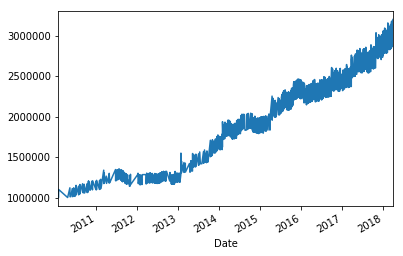

In [22]:
bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()